#  Taxi order forecasting

The Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Build a model to make this prediction.

The *RMSE* metric value on the test sample should be no more than 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on a test sample and draw conclusions.


The data is in the file `taxi.csv`. The number of orders is in the `num_orders` column (from the English *number of orders*, “number of orders”).

## Data preparation

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import time

RANDOM_STATE=12345

In [2]:
orders=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
orders.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
orders.index.is_monotonic

True

In [6]:
orders.isna().sum()

num_orders    0
dtype: int64

In [7]:
orders=orders.resample('1H').sum()

### Conclusion

The data is in chronological order, there are no gaps, and the data type is correct. Changed the interval from 10 minutes to 1 hour. Now we can start data analysis

## Data analysis

In [8]:
decomposed_orders=seasonal_decompose(orders)

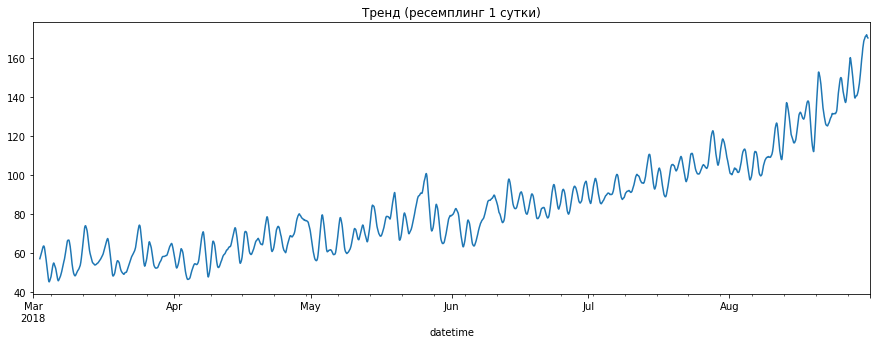

In [9]:
plt.title('Тренд (ресемплинг 1 сутки)')
decomposed_orders.trend.rolling(24).mean().plot(figsize=(15, 5))
plt.show()

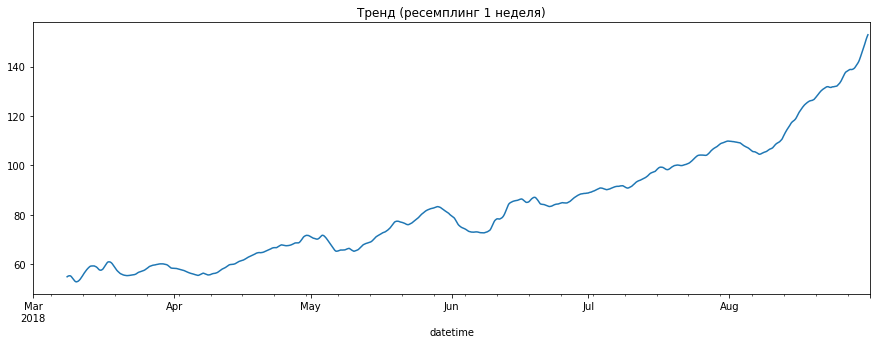

In [10]:
plt.title('Тренд (ресемплинг 1 неделя)')
decomposed_orders.trend.rolling(24*7).mean().plot(figsize=(15, 5))
plt.show()

In both graphs we see an increase in the number of orders during the year, from 60 to 160

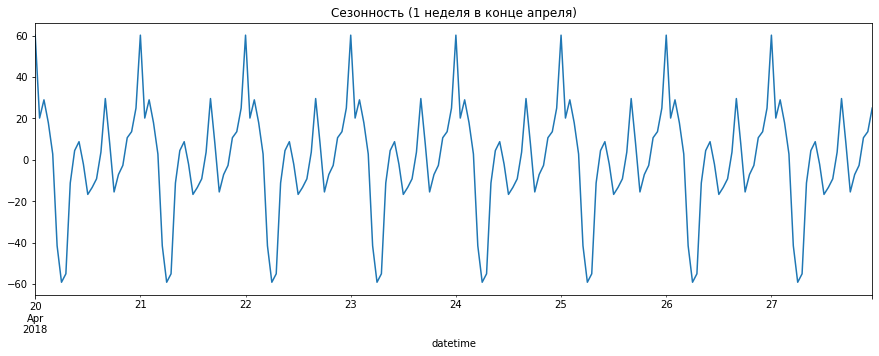

In [11]:
seasonal_orders=decomposed_orders.seasonal['2018-04-20':'2018-04-27']
plt.title('Сезонность (1 неделя в конце апреля)')
seasonal_orders.plot(figsize=(15,5))
plt.show()

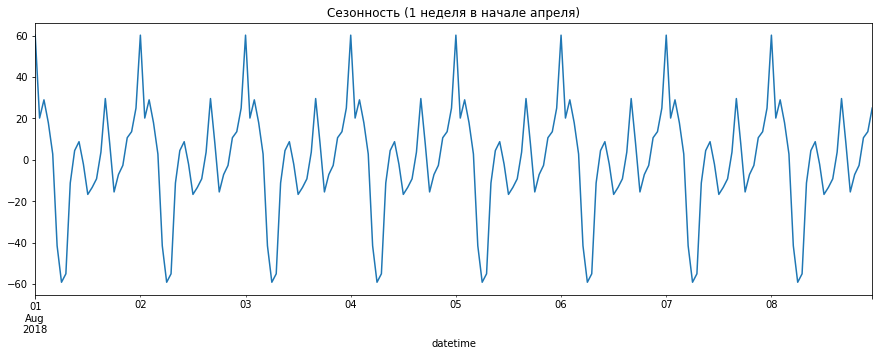

In [12]:
seasonal_orders=decomposed_orders.seasonal['2018-08-01':'2018-08-08']
plt.title('Сезонность (1 неделя в начале апреля)')
seasonal_orders.plot(figsize=(15,5))
plt.show()

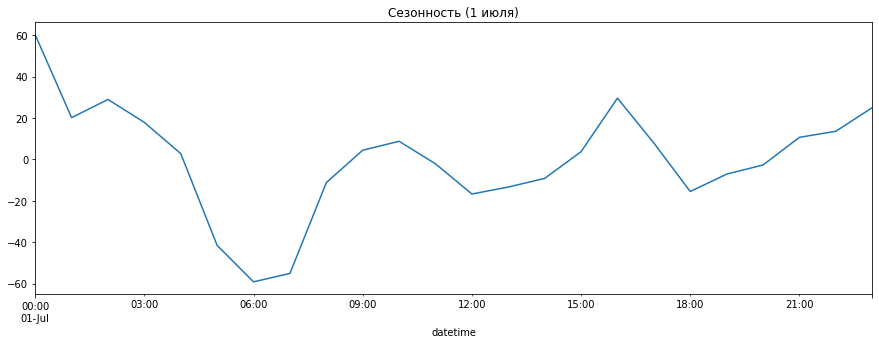

In [13]:
seasonal_orders=decomposed_orders.seasonal['2018-07-01':'2018-07-01']
plt.title('Сезонность (1 июля)')
seasonal_orders.plot(figsize=(15,5))
plt.show()

We took two weeks, at the end of April and at the beginning of August, to compare seasonality, as well as 1 day to understand the demand during the day.

### Conclusion

There is a growth trend throughout the year. There are small subsidences at the beginning of May, June and August, but they do not affect the overall picture.

Seasonality is also clearly pronounced and three peaks of demand are visible: morning, evening and midnight.

## Models training

In [14]:
def make_features(data_initial, max_lag, rolling_mean_size):
    data=data_initial.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour']=data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [15]:
orders_after=make_features(orders, 24, 6)
orders_after.head(10)

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.833333
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.166667
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000


In [16]:
train, test = train_test_split(orders_after, shuffle=False, test_size=0.1)
train = train.dropna()

features_train=train.drop('num_orders', axis=1)
target_train=train['num_orders']
features_test=test.drop('num_orders', axis=1)
target_test=test['num_orders']

In [17]:
print("Features_train size:", features_train.shape[0])
print("Target_train size:", target_train.shape[0])
print()
print("Features_test size:", features_test.shape[0])
print("Target_test size:", target_test.shape[0])

Features_train size: 3950
Target_train size: 3950

Features_test size: 442
Target_test size: 442


### Decision Tree

In [18]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[RANDOM_STATE]}]

tscv = TimeSeriesSplit(n_splits=15)
clf_dt = GridSearchCV(regressor, hyperparams, cv=tscv, scoring='neg_mean_squared_error')
clf_dt.fit(features_train, target_train)
print("Best parameters:", clf_dt.best_params_)
best= clf_dt.cv_results_['mean_test_score']
mean=clf_dt.cv_results_['mean_test_score'].mean()
print("Best RMSE:", (max(best)*-1) ** 0.5)
print("Mean RMSE:", (mean*-1) ** 0.5)

Best parameters: {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
Best RMSE: 27.891984525592633
Mean RMSE: 32.28673069858274
CPU times: user 17 s, sys: 27.3 ms, total: 17 s
Wall time: 17 s


### CatBoost

In [19]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[RANDOM_STATE],
                'verbose':[False]}]

tscv = TimeSeriesSplit(n_splits=15)
clf_cb = GridSearchCV(regressor, hyperparams, cv=tscv, scoring='neg_mean_squared_error')
clf_cb.fit(features_train, target_train)
print("Best parameters:", clf_cb.best_params_)
best= clf_cb.cv_results_['mean_test_score']
mean=clf_cb.cv_results_['mean_test_score'].mean()
print("Best RMSE:", (max(best)*-1) ** 0.5)
print("Mean RMSE:", (mean*-1) ** 0.5)

Best parameters: {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
Best RMSE: 23.165108195742153
Mean RMSE: 25.272892310895237
CPU times: user 3min 52s, sys: 4.98 s, total: 3min 57s
Wall time: 4min 48s


### Random Forest

In [20]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'n_estimators':range(50,100,10),
                'max_depth':range(5,15,2),
                'random_state':[RANDOM_STATE]}]

tscv = TimeSeriesSplit(n_splits=15)
clf_rnd = GridSearchCV(regressor, hyperparams, cv=tscv, scoring='neg_mean_squared_error')
clf_rnd.fit(features_train, target_train)
print("Best parameters:", clf_rnd.best_params_)
best= clf_rnd.cv_results_['mean_test_score']
mean=clf_rnd.cv_results_['mean_test_score'].mean()
print("Best RMSE:", (max(best)*-1) ** 0.5)
print("Mean RMSE:", (mean*-1) ** 0.5)

Best parameters: {'max_depth': 13, 'n_estimators': 90, 'random_state': 12345}
Best RMSE: 24.092627185167313
Mean RMSE: 24.700973375737572
CPU times: user 7min 22s, sys: 732 ms, total: 7min 23s
Wall time: 7min 23s


### Conclusion

Using the function, we created features for prediction. The sample was divided into training and testing (90% and 10%). We selected hyperparameters for 3 models: Decision Tree, CatBoost and Random Forest.

## Testing

In [21]:
%%time
model = CatBoostRegressor(**clf_cb.best_params_) 
model.fit(features_train, target_train)
target_predict_cb = model.predict(features_test)
CBR_rmse = mean_squared_error(target_test, target_predict_cb) ** 0.5
print("CatBoost RMSE (test dataframe):", CBR_rmse)

CatBoost RMSE (test dataframe): 38.7852103287795
CPU times: user 6.24 s, sys: 64.5 ms, total: 6.31 s
Wall time: 7.42 s


### Visualization of results

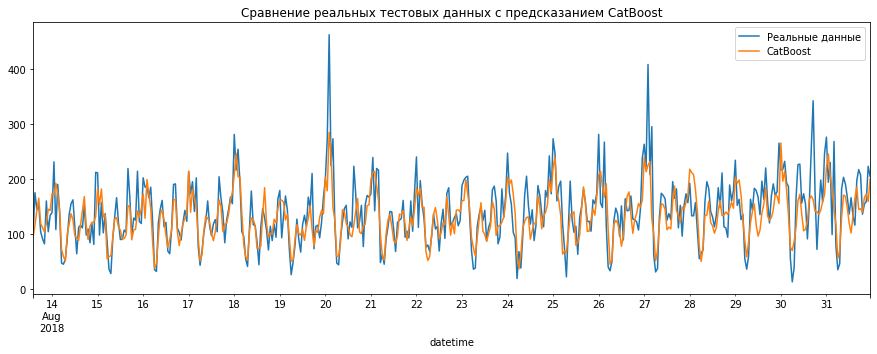

In [22]:
comparison = pd.DataFrame({"Реальные данные":target_test, "CatBoost":target_predict_cb})
comparison.plot(figsize=(15, 5))
plt.title('Сравнение реальных тестовых данных с предсказанием CatBoost')
plt.show()

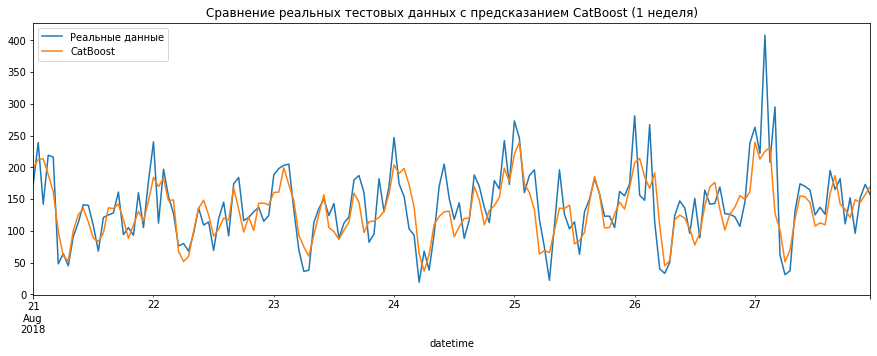

In [23]:
comparison = pd.DataFrame({"Реальные данные":target_test, "CatBoost":target_predict_cb})
comparison['2018-08-21':'2018-08-27'].plot(figsize=(15, 5))
plt.title('Сравнение реальных тестовых данных с предсказанием CatBoost (1 неделя)')
plt.show()

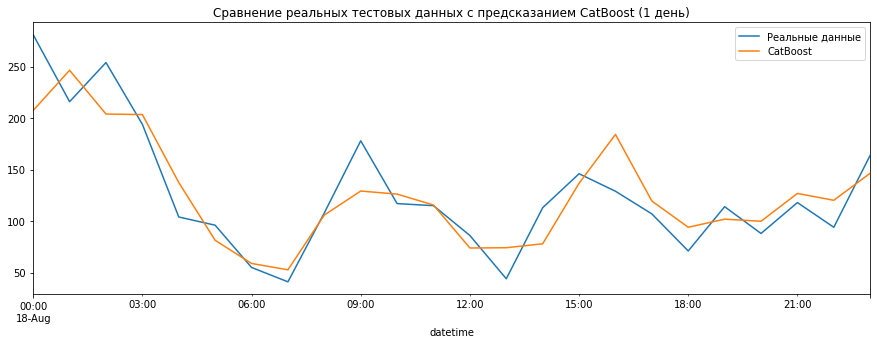

In [24]:
comparison = pd.DataFrame({"Реальные данные":target_test, "CatBoost":target_predict_cb})
comparison['2018-08-18':'2018-08-18'].plot(figsize=(15, 5))
plt.title('Сравнение реальных тестовых данных с предсказанием CatBoost (1 день)')
plt.show()

### Conclusion

The fastest model is Decision Tree. It learns the fastest and makes predictions, but at the same time it has the worst root mean square error.

The average model in terms of characteristics is Random Forest. It takes longer to train and predict, but the RMSE is 20% better.

The optimal model is CatBoost. It takes a very long time to train, but the prediction time is comparable to Decision Tree, and the RMSE is better than Random Forest.